# Business Problem:

## Background

Add Information Education/Grad rates in the Tri-State area

The Northeast includes Maine, New Hampshire, Vermont, Massachusetts, Rhode Island, Connecticut, New York, New Jersey, and Pennsylvania.

## Problem Statement

Predict which schools have high and which schools have low high school graduation rates. Identify which characteristics are the best indicator of high and low graduation rates so that school districts know where to focus resources when attempting to increase high school graduation rates.

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
# import xgboost as xgb
import catboost
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from catboost import Pool, sum_models
from catboost import CatBoostClassifier
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, balanced_accuracy_score
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,  OneHotEncoder, MinMaxScaler, StandardScaler 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform, truncnorm, randint


# Data Exploration and Prep

## Data Load

In [2]:
#New York school and district data
df_school_NY = pd.read_csv('data/EducationDataPortal_schools_NY.csv')
df_district_NY = pd.read_csv('data/EducationDataPortal_districts_NY.csv')

In [3]:
#Pennsylvania school and district data 
df_school_PA = pd.read_csv('data/EducationDataPortal_schools_PA.csv')
df_district_PA = pd.read_csv('data/EducationDataPortal_districts_PA.csv')

In [4]:
#New Jersey school and district data
df_school_NJ = pd.read_csv('data/EducationDataPortal_schools_PA.csv')
df_district_NJ = pd.read_csv('data/EducationDataPortal_districts_PA.csv')

## Functions

In [5]:
# Returns the percentage of values in a dataframe that are nulls
def percent_null_df (df,str_name):
    count_null = df.isnull().sum().sum()
    count_non_null = df.count().sum()
    return 'percent of nulls in '+ str_name +' is '+str(int((count_null/(count_null + count_non_null))*100))+'%'
    

## df_school

In [6]:
#Concatenate school info for all three states into one dataframe
df_school = pd.concat([df_school_NY, df_school_PA, df_school_NJ])

### Data Fields

In [7]:
df_school.head()

,year,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
0,2015,360000104498,JAMES A GREEN HIGH SCHOOL,New York,DOLGEVILLE CENTRAL SCHOOL DISTRICT,13329,"Rural, distant",High,Regular school,No,...,28.0,10.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
1,2015,360000204500,SAUQUOIT VALLEY HIGH SCHOOL,New York,SAUQUOIT VALLEY CENTRAL SCHOOL DISTRICT,13456,"Rural, fringe",High,Regular school,No,...,43.0,28.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0
2,2015,360000304543,EDWARDS-KNOX JUNIOR-SENIOR HIGH SCHOOL,New York,EDWARDS-KNOX CENTRAL SCHOOL DISTRICT,13652,"Rural, remote",High,Regular school,No,...,16.0,13.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
3,2015,360000404545,MOHONASEN SENIOR HIGH SCHOOL,New York,ROTTERDAM-MOHONASEN CENTRAL SCHOOL DISTRICT,12303,"Suburb, large",High,Regular school,No,...,107.0,41.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,606.0
4,2015,360000500282,BROADALBIN-PERTH HIGH SCHOOL,New York,BROADALBIN-PERTH CENTRAL SCHOOL DISTRICT,12025,"Rural, distant",High,Regular school,No,...,32.0,29.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0


In [8]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7181 entries, 0 to 3077
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             7181 non-null   int64  
 1   ncessch                          7181 non-null   int64  
 2   school_name                      7181 non-null   object 
 3   state_name                       7181 non-null   object 
 4   lea_name                         7181 non-null   object 
 5   zip_location                     7181 non-null   int64  
 6   urban_centric_locale             7181 non-null   object 
 7   school_level                     7181 non-null   object 
 8   school_type                      7181 non-null   object 
 9   charter                          7181 non-null   object 
 10  enrollment                       7063 non-null   object 
 11  read_test_num_valid              6782 non-null   float64
 12  read_test_pct_prof_l

### school_type

In [9]:
df_school['school_type'].value_counts(normalize=True, dropna=False)

Regular school              0.962401
Vocational school           0.026319
Other/alternative school    0.007520
Special education school    0.003760
Name: school_type, dtype: float64

In [10]:
df_school_regular = df_school.loc[df_school['school_type'] == 'Regular school']
df_school_regular

,year,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
0,2015,360000104498,JAMES A GREEN HIGH SCHOOL,New York,DOLGEVILLE CENTRAL SCHOOL DISTRICT,13329,"Rural, distant",High,Regular school,No,...,28.0,10.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
1,2015,360000204500,SAUQUOIT VALLEY HIGH SCHOOL,New York,SAUQUOIT VALLEY CENTRAL SCHOOL DISTRICT,13456,"Rural, fringe",High,Regular school,No,...,43.0,28.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0
2,2015,360000304543,EDWARDS-KNOX JUNIOR-SENIOR HIGH SCHOOL,New York,EDWARDS-KNOX CENTRAL SCHOOL DISTRICT,13652,"Rural, remote",High,Regular school,No,...,16.0,13.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
3,2015,360000404545,MOHONASEN SENIOR HIGH SCHOOL,New York,ROTTERDAM-MOHONASEN CENTRAL SCHOOL DISTRICT,12303,"Suburb, large",High,Regular school,No,...,107.0,41.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,606.0
4,2015,360000500282,BROADALBIN-PERTH HIGH SCHOOL,New York,BROADALBIN-PERTH CENTRAL SCHOOL DISTRICT,12025,"Rural, distant",High,Regular school,No,...,32.0,29.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009,2015,422685004657,York Suburban MS,Pennsylvania,York Suburban SD,17402,"Suburb, midsize",Middle,Regular school,No,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3010,2015,422685004658,York Suburban SHS,Pennsylvania,York Suburban SD,17403,"Suburb, midsize",High,Regular school,No,...,236.0,148.0,208.0,0.0,0.0,0.0,0.0,0.0,0.0,189.0
3011,2015,422685006688,Indian Rock El Sch,Pennsylvania,York Suburban SD,17403,"Suburb, midsize",Primary,Regular school,No,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3012,2015,422685007305,Valley View El Sch,Pennsylvania,York Suburban SD,17403,"Suburb, midsize",Primary,Regular school,No,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_school_alternative = df_school.loc[df_school['school_type'] == 'Other/alternative school']
df_school_alternative

,year,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
13,2015,360001706539,ALLEGANY CO SHERIFF C/O TREASURER,New York,GENESEE VALLEY CENTRAL SCHOOL DISTRICT,14813,"Rural, distant",High,Other/alternative school,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2015,360001806526,CHAUTAUQUA COUNTY JAIL,New York,CHAUTAUQUA LAKE CENTRAL SCHOOL DISTRICT,14757,"Rural, distant",High,Other/alternative school,No,...,NaN,NaN,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,2015,360005304411,JOHN V LINDSAY WILDCAT ACADEMY CHARTER SCHOOL,New York,JOHN V LINDSAY WILDCAT ACADEMY CHARTER SCHOOL,10004,"City, large",High,Other/alternative school,Yes,...,17.0,NaN,176.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
21,2015,360007600624,LOWER EAST SIDE PREPARATORY HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 1,10002,"City, large",High,Other/alternative school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,30.0
23,2015,360007603352,CASCADES HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 1,10002,"City, large",High,Other/alternative school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,14.0
33,2015,360007700637,LIBERTY HIGH SCHOOL ACADEMY FOR NEWCOMERS,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 2,10011,"City, large",High,Other/alternative school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,19.0
34,2015,360007700649,HS 560 CITY-AS-SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 2,10014,"City, large",High,Other/alternative school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,25.0
62,2015,360007705566,INDEPENDENCE HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 2,10019,"City, large",High,Other/alternative school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,4.0
87,2015,360007800619,EDWARD A REYNOLDS WEST SIDE HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 3,10025,"City, large",High,Other/alternative school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,4.0
107,2015,360008105758,HARLEM RENAISSANCE HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 5,10035,"City, large",High,Other/alternative school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,8.0


In [12]:
df_school_vocational = df_school.loc[df_school['school_type'] == 'Vocational school']
df_school_vocational

,year,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
41,2015,360007701911,ART AND DESIGN HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 2,10019,"City, large",High,Vocational school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,190.0
42,2015,360007701934,CHELSEA CAREER AND TECHNICAL EDUCATION HIGH SC...,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 2,10013,"City, large",High,Vocational school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,60.0
43,2015,360007701949,HIGH SCHOOL OF FASHION INDUSTRIES (THE),New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 2,10011,"City, large",High,Vocational school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,463.0
52,2015,360007704519,HIGH SCHOOL OF GRAPHIC COMMUNICATION ARTS,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 2,10019,"City, large",High,Vocational school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,14.0
120,2015,360008401909,ALFRED E SMITH CAREER AND TECHNICAL HIGH SCHOOL,New York,NEW YORK CITY GEOGRAPHIC DISTRICT # 7,10451,"City, large",High,Vocational school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3073,2015,428062007104,Schuylkill Technology Centers-South Camp,Pennsylvania,Schuylkill Technology Centers,17951,"Town, distant",High,Vocational school,No,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3074,2015,428063007105,Seneca Highlands Career and Technical Ce,Pennsylvania,Seneca Highlands Career and Technical Center,16743,"Rural, remote",High,Vocational school,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,2015,428066007107,Indiana County Technology Center,Pennsylvania,Indiana County Technology Center,15701,"Rural, fringe",High,Vocational school,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,2015,428067007108,Keystone Central CTC,Pennsylvania,Keystone Central CTC,17751,"Rural, fringe",High,Vocational school,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_school_special = df_school.loc[df_school['school_type'] == 'Special education school']
df_school_special

,year,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
395,2015,360013500806,PS 373 BROOKLYN TRANSITION CENTER,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,11206,"City, large",High,Special education school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0
396,2015,360013501923,PS 721 STEVEN MCSWEENEY SCHOOL,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,10461,"City, large",High,Special education school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,18.0
397,2015,360013502026,PS 721 MANHATTAN OCCUPATIONAL TRAINING CENTER,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,10014,"City, large",High,Special education school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,2.0
398,2015,360013502827,PS 371 LILLIAN L RASHKIS,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,11232,"City, large",High,Special education school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,6.0
399,2015,360013502844,PS 811,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,10459,"City, large",High,Special education school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,2.0
400,2015,360013502859,JOHN F KENNEDY JR SCHOOL,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,11373,"City, large",High,Special education school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,2.0
401,2015,360013502870,MANHATTAN SCHOOL FOR CAREER DEVELOPMENT,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,10003,"City, large",High,Special education school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,4.0
402,2015,360013504319,PS 753 SCHOOL FOR CAREER DEVELOPMENT,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,11238,"City, large",High,Special education school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0
403,2015,360013504481,QUEENS TRANSITION CENTER,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,11436,"City, large",High,Special education school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,4.0
404,2015,360013504522,JM RAPPORT SCHOOL FOR CAREER DEVELOPMENT,New York,NYC SPECIAL SCHOOLS - DISTRICT 75,10455,"City, large",High,Special education school,No,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,2.0


In [14]:
#Proportion of nulls regular school type
percent_null_df(df_school_regular,'df_school_regular')

'percent of nulls in df_school_regular is 15%'

In [15]:
#Proportion of nulls vocational school type
percent_null_df(df_school_vocational,'df_school_vocational')

'percent of nulls in df_school_vocational is 43%'

In [16]:
#Proportion of nulls alternative school type
percent_null_df(df_school_alternative,'df_school_alternative')

'percent of nulls in df_school_alternative is 31%'

In [17]:
#Proportion of nulls special education school type
percent_null_df(df_school_special,'df_school_special')

'percent of nulls in df_school_special is 31%'

Our Other/alternative school in the school_type field includes jails and detention centers. Many of these correctional facilities have a lot of NaN values in other data fields. We will remove all rows with alternative schools since there seems to be many missing values for these types of schools and because students in these types of schools are experiencing circumstances and educational experiences very different from the majority of students.

We will also remove vocational and special education school types as these school types are a small percentage of the data and have high proportion of nulls

In [18]:
df_school.shape[0]

7181

In [19]:
df_school.drop(df_school[df_school['school_type'] == 'Other/alternative school' ].index, inplace = True)
df_school.shape[0]

7047

In [20]:
df_school.drop(df_school[df_school['school_type'] == 'Vocational school' ].index, inplace = True)
df_school.shape[0]

6810

In [21]:
df_school.drop(df_school[df_school['school_type'] == 'Special education school' ].index, inplace = True)
df_school.shape[0]

6748

### Drop all subject enrollment columns

In [22]:
#Let's look at how many nulls we are dealing with now
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 15%'

In [23]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6748 entries, 3 to 3013
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             6748 non-null   int64  
 1   ncessch                          6748 non-null   int64  
 2   school_name                      6748 non-null   object 
 3   state_name                       6748 non-null   object 
 4   lea_name                         6748 non-null   object 
 5   zip_location                     6748 non-null   int64  
 6   urban_centric_locale             6748 non-null   object 
 7   school_level                     6748 non-null   object 
 8   school_type                      6748 non-null   object 
 9   charter                          6748 non-null   object 
 10  enrollment                       6636 non-null   object 
 11  read_test_num_valid              6432 non-null   float64
 12  read_test_pct_prof_l

The class subject enrollment columns stand out as having the most null values let's drop those columns.

In [24]:
df_school = df_school.drop(['enrl_biology', 'enrl_chemistry','enrl_advanced_math',
                            'enrl_calculus','enrl_algebra2','enrl_physics',
                            'enrl_geometry'], axis=1)

In [25]:
#How do our nulls look
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 8%'

### Graduation Rate - format the target

- The graduation rates are numerical values separated into three columns.
 - grad_rate_high
 - grad_rate_midpt 
 - grad_rate_low
 
- Looking at the data documentation from EDFacts https://www2.ed.gov/about/inits/ed/edfacts/index.htmlThe we see that the reason for multiple columns is that some schools choose to report graduation rates in a range so that student privacy is protected. The range creates a low and a high column with the midpoint being the value in the middle of the low and high values.
- We will use grad_rate_midpt to measure graduation rates as this is the most balanced.


- The federal government defines graduation rates as low when less than 2/3 of a cohort receive a diploma in 4 years or less.  
- We will classify high schools with midpoint graduation rates 66 and below as low and high schools with midpoint graduation rates of 67 and above as high.


In [26]:
grad_rate_cols = ['school_name','cohort_num','grad_rate_high','grad_rate_midpt',
                  'grad_rate_low']

In [27]:
df_school[grad_rate_cols].head(10)

,school_name,cohort_num,grad_rate_high,grad_rate_midpt,grad_rate_low
3,MOHONASEN SENIOR HIGH SCHOOL,227.0,85,85,85
4,BROADALBIN-PERTH HIGH SCHOOL,132.0,94,92,90
5,JASPER-TROUPSBURG JUNIOR-SENIOR HIGH SCHOOL,49.0,79,74,70
6,BELLPORT SENIOR HIGH SCHOOL,349.0,84,84,84
7,SARANAC HIGH SCHOOL,131.0,89,87,85
8,WAYLAND-COHOCTON HIGH SCHOOL,103.0,94,92,90
9,ONEIDA SENIOR HIGH SCHOOL,171.0,84,82,80
10,WATERLOO HIGH SCHOOL,151.0,89,87,85
11,ALLEGANY-LIMESTONE HIGH SCHOOL,86.0,89,87,85
12,AVERILL PARK HIGH SCHOOL,259.0,96,96,96


In [28]:
df_school = df_school.drop(['grad_rate_high','grad_rate_low'], axis=1)

In [29]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6748 entries, 3 to 3013
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             6748 non-null   int64  
 1   ncessch                          6748 non-null   int64  
 2   school_name                      6748 non-null   object 
 3   state_name                       6748 non-null   object 
 4   lea_name                         6748 non-null   object 
 5   zip_location                     6748 non-null   int64  
 6   urban_centric_locale             6748 non-null   object 
 7   school_level                     6748 non-null   object 
 8   school_type                      6748 non-null   object 
 9   charter                          6748 non-null   object 
 10  enrollment                       6636 non-null   object 
 11  read_test_num_valid              6432 non-null   float64
 12  read_test_pct_prof_l

In [30]:
df_school.drop(df_school[df_school['grad_rate_midpt'] == 'Suppressed data' ].index, inplace = True)
df_school.shape[0]

6719

In [31]:
df_school['grad_rate_midpt'].value_counts(normalize=True,dropna=False)

NaN    0.672273
97     0.056705
92     0.054770
87     0.032594
95     0.023367
         ...   
33     0.000149
36     0.000149
58     0.000149
60     0.000149
30     0.000149
Name: grad_rate_midpt, Length: 75, dtype: float64

In [32]:
df_school.update(df_school[['grad_rate_midpt']].fillna(0))

In [33]:
df_school.drop(df_school[df_school['grad_rate_midpt'] == 0 ].index, inplace = True)
df_school.shape[0]

1506

In [34]:
# convert grad rate columns to numeric
df_school[['grad_rate_midpt']] = df_school[['grad_rate_midpt']].astype(str).astype(int)


In [35]:
# Let's take a look at the summary statistics for the grad_rate_midpt column

print(df_school['grad_rate_midpt'].describe())


count    1506.000000
mean       86.754316
std        15.313796
min         2.000000
25%        87.000000
50%        92.000000
75%        96.000000
max        99.000000
Name: grad_rate_midpt, dtype: float64


In [36]:
 print('grad_rate_midpt', '\n', df_school['grad_rate_midpt'].value_counts(normalize=True).head(), '\n\n')

grad_rate_midpt 
 92    0.192563
97    0.187915
87    0.108234
95    0.080345
96    0.033201
Name: grad_rate_midpt, dtype: float64 




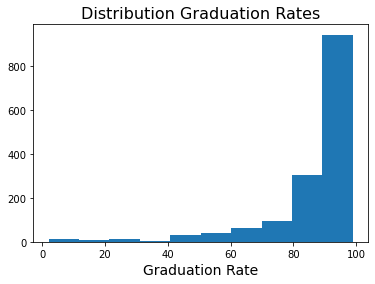

In [37]:
# Plot of the target status group

plt.hist(df_school['grad_rate_midpt'])
plt.xlabel('Graduation Rate', fontsize=14)
plt.title("Distribution Graduation Rates", fontsize=16)
plt.show()


It looks like there is a strong skew towards higher performing high schools. Lets go ahead and bin our values and then take a look at the distribution again.

#### Bin the target

As stated above based on how the federal government defines low graduation rates we will be dividing graduation rates into two bins:
- Low: 66 and below
- High: 67 and above

In [41]:
#Based on the federal government's definition we will define the bin ranges.
tsh_bins = [-1,0,20,350000]
grad_rate_bins = [0,66,100]

In [42]:
# now lets convert the grad_rate_midpt column to binned categories
# note that when binning these, the default setting is that the values on the right are included in the bin

df_school['grad_rate_midpt'] = pd.cut(df_school['grad_rate_midpt'], grad_rate_bins)

In [46]:
# and we will also take a look at the distribution across bins 
print(df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False))

(66, 100]    0.916999
(0, 66]      0.083001
Name: grad_rate_midpt, dtype: float64


In [ ]:
# We need to address this class imbalance


### Reading and Math Tests

In [39]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1506 entries, 3 to 3010
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             1506 non-null   int64  
 1   ncessch                          1506 non-null   int64  
 2   school_name                      1506 non-null   object 
 3   state_name                       1506 non-null   object 
 4   lea_name                         1506 non-null   object 
 5   zip_location                     1506 non-null   int64  
 6   urban_centric_locale             1506 non-null   object 
 7   school_level                     1506 non-null   object 
 8   school_type                      1506 non-null   object 
 9   charter                          1506 non-null   object 
 10  enrollment                       1506 non-null   object 
 11  read_test_num_valid              1504 non-null   float64
 12  read_test_pct_prof_l

In [ ]:
df_school_special = df_school.loc[df_school['school_type'] == 'Special education school']
df_school_special

In [ ]:
percent_null = ((1506-992)/1506)*100
percent_null

The read_test_num_valid column and the math_test_num_valid column desribe the Number of students who completed a reading, and math assessment and for whom a proficiency level was assigned

The low, high, and midpt columns describe the low, high, and midpoint of the range used to report the share of students scoring proficient on a reading or language arts assessment (0–100 scale)

A small percentage of these columns are null (3.2%). We need to investigate these columns to figure out if we want to keep them and how to address the nulls if we do.

In [ ]:
read_test = ['school_name', 'read_test_num_valid', 'read_test_pct_prof_low', 
             'read_test_pct_prof_high', 'read_test_pct_prof_midpt']

In [ ]:
df_school[read_test].head(20)

In [ ]:
math_test = ['school_name', 'math_test_num_valid' , 'math_test_pct_prof_low', 
             'math_test_pct_prof_high', 'math_test_pct_prof_midpt']

In [ ]:
df_school[math_test].head(20)

In [ ]:
df_district = pd.concat([df_district_NY, df_district_PA, df_district_NJ])

In [ ]:
df_district.head()

In [ ]:
df_district.info()

In [ ]:
df_district['enrollment'].value_counts(normalize=True,dropna=False)

In [ ]:
# Plot of the target status group

plt.hist(df_schools['grad_rate'])
plt.xlabel('grad_rate', fontsize=14)
plt.title("Distribution of Graduation Rate", fontsize=16)
plt.show()


In [ ]:
df_train['amount_tsh'].value_counts(normalize=True, dropna=False)

### Columns to drop

In [49]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1506 entries, 3 to 3010
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   ncessch                          1506 non-null   int64   
 1   school_name                      1506 non-null   object  
 2   state_name                       1506 non-null   object  
 3   lea_name                         1506 non-null   object  
 4   zip_location                     1506 non-null   int64   
 5   urban_centric_locale             1506 non-null   object  
 6   school_level                     1506 non-null   object  
 7   school_type                      1506 non-null   object  
 8   charter                          1506 non-null   object  
 9   enrollment                       1506 non-null   object  
 10  read_test_num_valid              1504 non-null   float64 
 11  read_test_pct_prof_low           1504 non-null   object  
 12  read_t

Drop year as this is the same for all rows

In [48]:
df_school = df_school.drop(['year'], axis=1)

## Missing Values

### Many Individual Values

### Not Significant

- Combine grad rates into single binary column
- Drop outlay_capital_arra 
- nulls in all enrl fields
- nulls in corp inst

## df_school

In [50]:
#Concatenate district info for all three states into one dataframe
df_district = pd.concat([df_district_NY, df_district_PA, df_district_NJ])

### Data Fields

In [52]:
df_district.head()

,year,leaid,lea_name,state_name,state_leaid,city_location,urban_centric_locale,agency_type,enrollment,english_language_learners,...,outlay_capital_instruc_equip,outlay_capital_other_equip,outlay_capital_nonspec_equip,salaries_total,salaries_instruction,benefits_employee_total,cohort_num,grad_rate_high,grad_rate_low,grad_rate_midpt
0,2015,3600001,DOLGEVILLE CENTRAL SCHOOL DISTRICT,New York,211003040000,DOLGEVILLE,"Rural, distant",Regular local school district,928,Missing/not reported,...,52000,498000,0,9357000,6683000,5053000,76.0,84,80,82
1,2015,3600002,SAUQUOIT VALLEY CENTRAL SCHOOL DISTRICT,New York,411603040000,SAUQUOIT,"Rural, fringe",Regular local school district,1055,4,...,0,369000,0,10433000,7323000,5564000,87.0,94,90,92
2,2015,3600003,EDWARDS-KNOX CENTRAL SCHOOL DISTRICT,New York,513102040000,HERMON,"Rural, remote",Regular local school district,599,Missing/not reported,...,1000,280000,0,6310000,4101000,4012000,52.0,79,70,74
3,2015,3600004,ROTTERDAM-MOHONASEN CENTRAL SCHOOL DISTRICT,New York,530515060000,SCHENECTADY,"Suburb, large",Regular local school district,2812,28,...,16000,648000,0,26195000,17815000,11884000,235.0,83,83,83
4,2015,3600005,BROADALBIN-PERTH CENTRAL SCHOOL DISTRICT,New York,171102040000,BROADALBIN,"Rural, distant",Regular local school district,1836,3,...,0,602000,0,17090000,12135000,8621000,133.0,94,90,92


In [53]:
df_district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2630 entries, 0 to 799
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             2630 non-null   int64  
 1   leaid                            2630 non-null   int64  
 2   lea_name                         2630 non-null   object 
 3   state_name                       2630 non-null   object 
 4   state_leaid                      2630 non-null   int64  
 5   city_location                    2630 non-null   object 
 6   urban_centric_locale             2630 non-null   object 
 7   agency_type                      2630 non-null   object 
 8   enrollment                       2542 non-null   object 
 9   english_language_learners        2542 non-null   object 
 10  est_population_total             1679 non-null   float64
 11  est_population_5_17_poverty      1679 non-null   float64
 12  est_population_5_17_p

In [54]:
#What proportion of our data frame is nulls?
percent_null_df(df_district,'df_district')

'percent of nulls in df_district is 4%'

Not bad. Let's deal with that 4%

### population columns

In [57]:
# Our population columns have the highest proportion of nulls let's take at look
population_cols = ['lea_name','state_name','est_population_total','est_population_5_17_poverty',
                           'est_population_5_17_poverty_pct']

In [61]:
is_NaN = df_district[population_cols].isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_district[row_has_NaN]

print(rows_with_NaN)

     year    leaid                                           lea_name  \
22   2015  3600024  CATTARAUGUS-LITTLE VALLEY CENTRAL SCHOOL DISTRICT   
23   2015  3600025            CHARTER SCHOOL FOR APPLIED TECHNOLOGIES   
24   2015  3600026             EUGENIO MARIA DE HOSTOS CHARTER SCHOOL   
25   2015  3600029                   GENESEE COMMUNITY CHARTER SCHOOL   
26   2015  3600030        ROOSEVELT CHILDREN'S ACADEMY CHARTER SCHOOL   
..    ...      ...                                                ...   
795  2015  4289350                              Delaware County IU 25   
796  2015  4289370                                Beaver Valley IU 27   
797  2015  4289380                                         ARIN IU 28   
798  2015  4289390                                   Schuylkill IU 29   
799  2015  4289393                                       Lycoming CTC   

       state_name   state_leaid city_location urban_centric_locale  \
22       New York   42302040000   CATTARAUGUS       R

In [62]:
rows_with_NaN.head(10)

,year,leaid,lea_name,state_name,state_leaid,city_location,urban_centric_locale,agency_type,enrollment,english_language_learners,...,outlay_capital_instruc_equip,outlay_capital_other_equip,outlay_capital_nonspec_equip,salaries_total,salaries_instruction,benefits_employee_total,cohort_num,grad_rate_high,grad_rate_low,grad_rate_midpt
22,2015,3600024,CATTARAUGUS-LITTLE VALLEY CENTRAL SCHOOL DISTRICT,New York,42302040000,CATTARAUGUS,"Rural, distant",Regular local school district,960,Missing/not reported,...,6000,698000,0,10781000,7262000,5436000,71.0,79,75,77
23,2015,3600025,CHARTER SCHOOL FOR APPLIED TECHNOLOGIES,New York,142601860031,BUFFALO,"Suburb, large",Charter agency,2039,53,...,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,117.0,100,95,97
24,2015,3600026,EUGENIO MARIA DE HOSTOS CHARTER SCHOOL,New York,261600860811,ROCHESTER,"City, midsize",Charter agency,415,38,...,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,NaN,NaN,NaN,NaN
25,2015,3600029,GENESEE COMMUNITY CHARTER SCHOOL,New York,261600860826,ROCHESTER,"City, midsize",Charter agency,219,3,...,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,NaN,NaN,NaN,NaN
26,2015,3600030,ROOSEVELT CHILDREN'S ACADEMY CHARTER SCHOOL,New York,280208860024,ROOSEVELT,"Suburb, large",Charter agency,648,28,...,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,NaN,NaN,NaN,NaN
27,2015,3600032,BRIGHTER CHOICE CHARTER SCHOOL FOR BOYS,New York,10100860829,ALBANY,"City, small",Charter agency,289,7,...,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,NaN,NaN,NaN,NaN
28,2015,3600033,BRIGHTER CHOICE CHARTER SCHOOL FOR GIRLS,New York,10100860830,ALBANY,"City, small",Charter agency,284,4,...,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,NaN,NaN,NaN,NaN
29,2015,3600035,KING CENTER CHARTER SCHOOL,New York,140600860814,BUFFALO,"City, large",Charter agency,395,14,...,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,NaN,NaN,NaN,NaN
30,2015,3600036,SOUTH BUFFALO CHARTER SCHOOL,New York,140600860817,BUFFALO,"City, large",Charter agency,909,8,...,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,NaN,NaN,NaN,NaN
31,2015,3600038,TAPESTRY CHARTER SCHOOL,New York,140600860838,BUFFALO,"City, large",Charter agency,826,9,...,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,Missing/not reported,80.0,94,90,92


In [ ]:
df_school = df_school.drop(['year','est_population_total','est_population_5_17_poverty',
                           'est_population_5_17_poverty_pct'], axis=1)

# Data Preparation

## Join Datasets

In [ ]:
df_train = df_school.merge(df_district, on = 'lea_name')
df_train.head()

In [ ]:
df_train.info()

In [ ]:
# print top 5 most frequent values in each column
for col in df_train_set.columns:
    print(col, '\n', df_train_set[col].value_counts(normalize=True).head(), '\n\n')


## Categorical and Numerical

### Join Target: df_train_set to df_train

### Column Binning

# Train Test Split

In [86]:
X=df_train.drop(columns = ['grad_rate']) # Features
y=df_train['grad_rate'] #Target

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [88]:
X_train

,id_left,amount_tsh,longitude,latitude,basin,region_code,district_code,lga,permit,construction_year,...,management_group,payment,quality_group,quantity,source_type,source_class,waterpoint_type,installer_new,funder_new,id_right
13863,46282,"(-1, 0]",39.198567,-7.564350,Rufiji,60,53,other,1,"(1985.0, 2005.0]",...,user-group,never pay,good,insufficient,shallow well,groundwater,hand pump,other,other,49235.0
52464,32809,"(20, 350000]",37.180087,-3.192072,Pangani,3,5,hai,1,"(1985.0, 2005.0]",...,user-group,other,good,enough,spring,groundwater,communal standpipe,ces,german group,68203.0
49573,33129,"(-1, 0]",35.420048,-8.418192,Rufiji,11,2,other,0,"(1985.0, 2005.0]",...,user-group,never pay,good,enough,shallow well,groundwater,hand pump,dwe,other,69545.0
46133,35725,"(20, 350000]",37.917789,-4.155432,Pangani,3,3,same,1,"(1985.0, 2005.0]",...,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,world vision,world vision,73372.0
1277,10355,"(-1, 0]",34.497217,-5.706788,Rufiji,13,3,other,0,"(1.0, 1985.0]",...,user-group,never pay,good,insufficient,borehole,groundwater,communal standpipe multiple,other,other,46247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28267,16272,"(-1, 0]",34.376661,-8.697432,Rufiji,12,7,mbarali,1,NaN,...,user-group,never pay,colored,seasonal,river/lake,surface,communal standpipe,other,other,26284.0
48544,57986,"(0, 20]",39.366473,-10.875261,Ruvuma / Southern Coast,90,33,other,0,"(1985.0, 2005.0]",...,user-group,pay per bucket,good,insufficient,spring,groundwater,other,other,unicef,74211.0
6440,37180,"(-1, 0]",39.448854,-10.622765,Ruvuma / Southern Coast,9,4,other,1,"(1.0, 1985.0]",...,user-group,never pay,good,enough,borehole,groundwater,communal standpipe,finw,finw,26771.0
46755,47703,"(20, 350000]",34.794685,-9.032680,Rufiji,11,4,njombe,1,"(2005.0, 2015.0]",...,user-group,pay monthly,good,enough,spring,groundwater,communal standpipe,other,other,9824.0


In [89]:
X_train.shape

(33244, 22)

In [90]:
X_test.shape

(14248, 22)

# Encode Features

In [91]:
df_train.columns

Index(['id_left', 'amount_tsh', 'longitude', 'latitude', 'basin',
       'region_code', 'district_code', 'lga', 'permit', 'construction_year',
       'extraction_type_group', 'management', 'management_group', 'payment',
       'quality_group', 'quantity', 'source_type', 'source_class',
       'waterpoint_type', 'installer_new', 'funder_new', 'id_right',
       'status_group'],
      dtype='object')

In [92]:
col_names = list(df_train.columns)

In [93]:
col_names_ohe = col_names

In [94]:
remove_ohe = ['id_left','id_right','permit','status_group','longitude','latitude']

In [95]:
for ele in remove_ohe:
    if ele in col_names_ohe:
        col_names_ohe.remove(ele)
col_names_ohe

['amount_tsh',
 'basin',
 'region_code',
 'district_code',
 'lga',
 'construction_year',
 'extraction_type_group',
 'management',
 'management_group',
 'payment',
 'quality_group',
 'quantity',
 'source_type',
 'source_class',
 'waterpoint_type',
 'installer_new',
 'funder_new']

In [96]:
X_train[col_names] = X_train[col_names_ohe].astype('category')
X_test[col_names] = X_test[col_names_ohe].astype('category')

In [97]:
X_train_ohe = X_train[col_names_ohe]
X_test_ohe = X_test[col_names_ohe]

## X_train Encode

In [98]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33244 entries, 13863 to 30980
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id_left                33244 non-null  int64   
 1   amount_tsh             33244 non-null  category
 2   longitude              33244 non-null  float64 
 3   latitude               33244 non-null  float64 
 4   basin                  33244 non-null  category
 5   region_code            33244 non-null  category
 6   district_code          33244 non-null  category
 7   lga                    33244 non-null  category
 8   permit                 33244 non-null  int64   
 9   construction_year      21674 non-null  category
 10  extraction_type_group  33244 non-null  category
 11  management             33244 non-null  category
 12  management_group       33244 non-null  category
 13  payment                33244 non-null  category
 14  quality_group          33244 non-n

Change Sci kit learn OHE set sparse to false set handle errors to ignore drop first equals if binary

In [99]:
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)

In [100]:
enc.fit(X_train_ohe) 

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [101]:
enc.categories_

[array([Interval(-1, 0, closed='right'), Interval(0, 20, closed='right'),
        Interval(20, 350000, closed='right')], dtype=object),
 array(['Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
        'Lake Victoria', 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast',
        'Wami / Ruvu'], dtype=object),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 24, 40, 60, 80, 90, 99]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 13, 23, 30, 33, 43, 53, 60, 62,
        63, 67, 80]),
 array(['arusha rural', 'bagamoyo', 'bariadi', 'hai', 'iringa rural',
        'kahama', 'karagwe', 'kasulu', 'kibondo', 'kigoma rural',
        'kilombero', 'kilosa', 'kwimba', 'kyela', 'lushoto', 'magu',
        'makete', 'maswa', 'mbarali', 'mbinga', 'mbozi', 'meru',
        'moshi rural', 'mpanda', 'mvomero', 'namtumbo', 'ngara', 'njombe',
        'other', 'rombo', 'rungwe', 'same', 'serengeti', 'singida rural',
        'songea rural', 'ulanga'], dtype=o

In [102]:
X_train2 = enc.transform(X_train_ohe)

In [103]:
X_train2.shape

(33244, 197)

In [104]:
enc.get_feature_names()
column_name = enc.get_feature_names()
one_hot_encoded_frame =  pd.DataFrame(X_train2, columns= column_name)

In [105]:
X_train = one_hot_encoded_frame.reset_index(drop=True).merge(X_train.reset_index(drop=True), left_index=True, right_index=True)


In [106]:
X_train.drop(col_names_ohe, axis=1, inplace=True)
X_train

,"x0_(-1, 0]","x0_(0, 20]","x0_(20, 350000]",x1_Internal,x1_Lake Nyasa,x1_Lake Rukwa,x1_Lake Tanganyika,x1_Lake Victoria,x1_Pangani,x1_Rufiji,...,x16_tasaf,x16_tcrs,x16_unicef,x16_world bank,x16_world vision,id_left,longitude,latitude,permit,id_right
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,46282,39.198567,-7.564350,1,49235.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,32809,37.180087,-3.192072,1,68203.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,33129,35.420048,-8.418192,0,69545.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,35725,37.917789,-4.155432,1,73372.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,10355,34.497217,-5.706788,0,46247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33239,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,16272,34.376661,-8.697432,1,26284.0
33240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,57986,39.366473,-10.875261,0,74211.0
33241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,37180,39.448854,-10.622765,1,26771.0
33242,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,47703,34.794685,-9.032680,1,9824.0


In [107]:
del X_train['id_left']
del X_train['id_right']

In [108]:
X_train

,"x0_(-1, 0]","x0_(0, 20]","x0_(20, 350000]",x1_Internal,x1_Lake Nyasa,x1_Lake Rukwa,x1_Lake Tanganyika,x1_Lake Victoria,x1_Pangani,x1_Rufiji,...,x16_private individual,x16_rwssp,x16_tasaf,x16_tcrs,x16_unicef,x16_world bank,x16_world vision,longitude,latitude,permit
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.198567,-7.564350,1
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.180087,-3.192072,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.420048,-8.418192,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37.917789,-4.155432,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.497217,-5.706788,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33239,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.376661,-8.697432,1
33240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39.366473,-10.875261,0
33241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.448854,-10.622765,1
33242,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.794685,-9.032680,1


## X_test Encode

In [109]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14248 entries, 50633 to 30177
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id_left                14248 non-null  int64   
 1   amount_tsh             14248 non-null  category
 2   longitude              14248 non-null  float64 
 3   latitude               14248 non-null  float64 
 4   basin                  14248 non-null  category
 5   region_code            14248 non-null  category
 6   district_code          14248 non-null  category
 7   lga                    14248 non-null  category
 8   permit                 14248 non-null  int64   
 9   construction_year      9298 non-null   category
 10  extraction_type_group  14248 non-null  category
 11  management             14248 non-null  category
 12  management_group       14248 non-null  category
 13  payment                14248 non-null  category
 14  quality_group          14248 non-n

In [110]:
enc.categories_

[array([Interval(-1, 0, closed='right'), Interval(0, 20, closed='right'),
        Interval(20, 350000, closed='right')], dtype=object),
 array(['Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
        'Lake Victoria', 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast',
        'Wami / Ruvu'], dtype=object),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 24, 40, 60, 80, 90, 99]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 13, 23, 30, 33, 43, 53, 60, 62,
        63, 67, 80]),
 array(['arusha rural', 'bagamoyo', 'bariadi', 'hai', 'iringa rural',
        'kahama', 'karagwe', 'kasulu', 'kibondo', 'kigoma rural',
        'kilombero', 'kilosa', 'kwimba', 'kyela', 'lushoto', 'magu',
        'makete', 'maswa', 'mbarali', 'mbinga', 'mbozi', 'meru',
        'moshi rural', 'mpanda', 'mvomero', 'namtumbo', 'ngara', 'njombe',
        'other', 'rombo', 'rungwe', 'same', 'serengeti', 'singida rural',
        'songea rural', 'ulanga'], dtype=o

In [111]:
X_test2 = enc.transform(X_test_ohe)

In [112]:
X_test2.shape

(14248, 197)

In [113]:
enc.get_feature_names()
column_name = enc.get_feature_names()
one_hot_encoded_frame =  pd.DataFrame(X_test2, columns= column_name)

In [114]:
X_test = one_hot_encoded_frame.reset_index(drop=True).merge(X_test.reset_index(drop=True), left_index=True, right_index=True)


In [115]:
X_test.drop(col_names_ohe, axis=1, inplace=True)
X_test

,"x0_(-1, 0]","x0_(0, 20]","x0_(20, 350000]",x1_Internal,x1_Lake Nyasa,x1_Lake Rukwa,x1_Lake Tanganyika,x1_Lake Victoria,x1_Pangani,x1_Rufiji,...,x16_tasaf,x16_tcrs,x16_unicef,x16_world bank,x16_world vision,id_left,longitude,latitude,permit,id_right
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,21684,32.029644,-3.356948,1,13741.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,14202,33.918430,-9.437514,1,45699.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7755,32.728018,-8.861211,0,48671.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,56771,37.548653,-6.252355,1,73381.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,14050,29.823993,-4.878173,1,36024.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,14133,30.712539,-1.330670,1,3508.0
14244,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9639,33.383450,-3.783168,0,62489.0
14245,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,58622,34.187547,-3.178968,0,59180.0
14246,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,33620,35.652858,-8.106353,1,52289.0


In [116]:
del X_test['id_left']
del X_test['id_right']

In [117]:
X_test

,"x0_(-1, 0]","x0_(0, 20]","x0_(20, 350000]",x1_Internal,x1_Lake Nyasa,x1_Lake Rukwa,x1_Lake Tanganyika,x1_Lake Victoria,x1_Pangani,x1_Rufiji,...,x16_private individual,x16_rwssp,x16_tasaf,x16_tcrs,x16_unicef,x16_world bank,x16_world vision,longitude,latitude,permit
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.029644,-3.356948,1
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.918430,-9.437514,1
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.728018,-8.861211,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,37.548653,-6.252355,1
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.823993,-4.878173,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.712539,-1.330670,1
14244,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.383450,-3.783168,0
14245,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.187547,-3.178968,0
14246,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.652858,-8.106353,1


In [118]:
X_train.shape

(33244, 200)

In [119]:
X_test.shape

(14248, 200)

# Model Development

# Might Use Later

In [38]:
# print top 5 most frequent values in each grad_rate column
for col in df_school['grad_rate_midpt'].columns:
    print(col, '\n', df_school[col].value_counts(normalize=True).head(), '\n\n')


AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
def target_col (row):
   if row['eri_hispanic   '] == 1 :
      return 'Hispanic'
   if row['eri_afr_amer'] + row['eri_asian'] + row['eri_hawaiian'] + row['eri_nat_amer'] + row['eri_white'] > 1 :
      return 'Two Or More'
   if row['eri_nat_amer'] == 1 :
      return 'A/I AK Native'
   if row['eri_asian'] == 1:
      return 'Asian'
   if row['eri_afr_amer']  == 1:
      return 'Black/AA'
   if row['eri_hawaiian'] == 1:
      return 'Haw/Pac Isl.'
   if row['eri_white'] == 1:
      return 'White'
   return 'Other'
